In [1]:
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



In [2]:
# use the mapping in zou and hastie y* = (y, 0)', X* = (X, sqrt(lambda_2)*I)
# to solve ridge regression by OLS and check it against
# both a "normal" ridge call and matrix inversion solutions

In [3]:
# generate data

N <- 100
P <- 200

# crucial to scale X and y, otherwise solutions are different
X <- scale(matrix( rnorm(N*P,mean=0,sd=1), N, P))

nz_beta <- c(1,-2,3,-4,5,-6,7,-8,9,10)
beta <- c(nz_beta,rep(0,P-length(nz_beta)))

sigma <- 0.1
y <- scale(X %*% beta + rnorm(N, mean=0, sd=sigma), scale = TRUE)

In [4]:
# pick some parameters for penalized regression. lambda_1 = 0 <==> ridge, lambda_2 = 0 <==> lasso

lambda_1 <- 0.0
lambda_2 <- 5.0

alpha <- lambda_1/(lambda_1+lambda_2)
lambda <- lambda_1+lambda_2

In [5]:
# fit a ridge regression to one lambda value
fit <- glmnet(X, y, alpha=alpha, lambda=lambda, intercept=FALSE, standardize=FALSE)
beta <- fit$beta

In [6]:
# create augmented data and params as in Zou & Hastie
# note the additional factor of sqrt(N) since glmnet uses
# (1/2N)||y-X*beta||_2^2 rrather than (1/2)||y-X*beta||_2^2
# in the objective

y_star <- c(y, rep(0,P))
X_star <- rbind(X, sqrt(N*lambda_2)*diag(P))/sqrt(1+lambda_2)
gamma <- lambda_1/sqrt(1+lambda_2)
alpha_star <- 1.0 # the point of the augmented data is it removes the ridge term

In [7]:
fit_augmented <- glmnet(X_star, y_star, alpha=0, lambda=0, intercept=FALSE, standardize=FALSE)
beta_star <- fit_augmented$beta
beta_augmented <- beta_star/sqrt(1+lambda_2)

In [8]:
# solve the ridge regression by matrix inversion
# beta = (X'X + lamba*I)^-1 * X'y

beta_mi <- solve(t(X) %*% X + N*lambda_2*diag(P)) %*% t(X) %*% y

In [9]:
# solve the ridge regression by matrix inversion in the augmented space
# beta* = (X*'X*)^-1 * X*'y* / sqrt(1+lambda_2)

beta_mi_augmented <- solve(t(X_star) %*% X_star) %*% t(X_star) %*% y_star / sqrt(1+lambda_2)

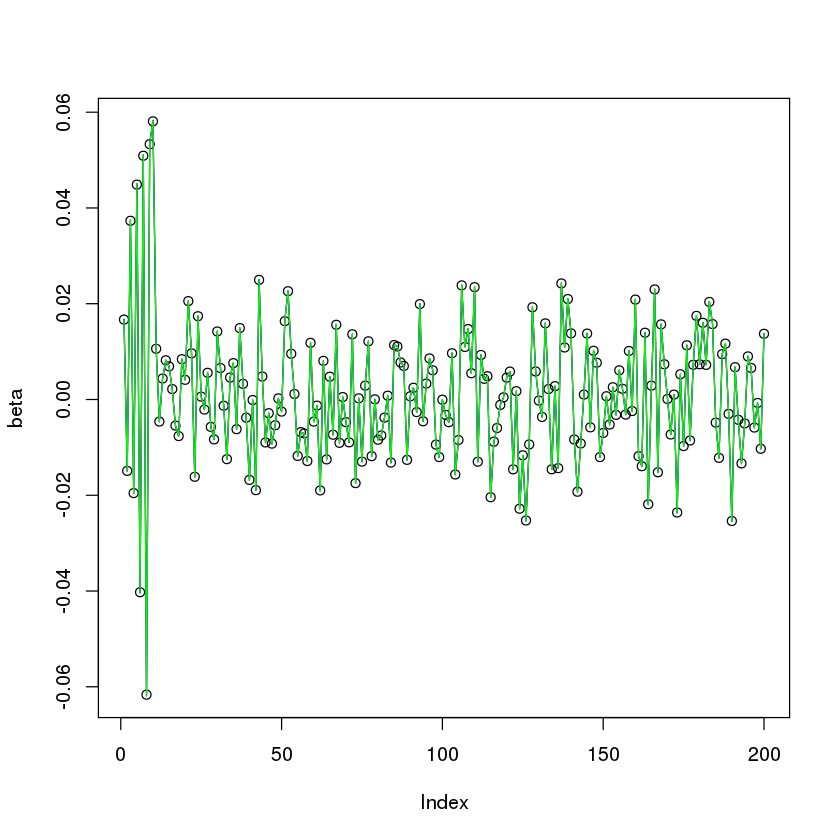

In [10]:
plot(beta, type='p', )
lines(beta_augmented, col='red')
lines(beta_mi, col='blue')
lines(beta_mi_augmented, col='green')